In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import time

from tensorflow.contrib.distributions import Normal, Gamma
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
# load data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
print("train: "+str(mnist.train.num_examples))
print("test: "+str(mnist.test.num_examples))

train: 55000
test: 10000


In [9]:
# model variables
N_FEATURES = 28*28
N_CLASSES = 10
ALPHA, BETA = 1., 0.1

N_TRAIN = mnist.train.num_examples
N_BATCH = 128

#stein variables
EL = 1e-3 
N_ITERATIONS = 5000#5000
M = 100 # number of particles

#adam variables
FUDGE_FACTOR = 1e-6
AUTO_CORR = 0.9

In [10]:
#create the first model
with tf.name_scope("model"):
    # variables
    model_x = tf.placeholder(tf.float32, [None, N_FEATURES])
    model_y = tf.placeholder(tf.float32, [None, N_CLASSES]) # one-hot-encoding
    model_w = tf.Variable(tf.zeros([N_FEATURES,N_CLASSES], dtype=tf.float32))
    model_b = tf.Variable(tf.zeros([N_CLASSES], dtype=tf.float32))
    model_log_lambda = tf.Variable(tf.zeros([]))
    model_lambda = tf.exp(model_log_lambda)

    with tf.name_scope("prediction"):
        model_prediction = tf.nn.softmax(tf.matmul(model_x,model_w)+model_b) # y = softmax(w*x+b)
    
    with tf.name_scope("likelihood"):
        log_prediction = tf.log(model_prediction) # log p(y=i|x,w), for i = 0,...,9
        #use the true label, we need for x_i log p(y=y_i|x_i,w)
        log_like = tf.reduce_sum(model_y * log_prediction, 1) 
        log_likelihood = tf.reduce_sum(log_like) #log p(D|w)
    
    with tf.name_scope("priors"):
        prior_lambda = Gamma(ALPHA, BETA)
        prior_w = Normal(
            tf.zeros([N_FEATURES, N_CLASSES]),
            1.#tf.reciprocal(tf.sqrt(model_lambda))
        )
        prior_b = Normal(
            tf.zeros([N_CLASSES]),
            1.#tf.reciprocal(tf.sqrt(model_lambda))
        )
    
    log_p = (
        log_likelihood * N_TRAIN / N_BATCH +
        # Variance priors.
        prior_lambda.log_prob(model_log_lambda) +
        # Weight and bias priors.
        tf.reduce_sum(prior_w.log_prob(model_w)) +
        tf.reduce_sum(prior_b.log_prob(model_b))
    )
        
    m_grad_log_p = tf.gradients(log_p, [model_w, model_b, model_log_lambda])

In [11]:
def get_real_median(v):
    v = tf.reshape(v, [-1])
    l = v.get_shape()[0]
    mid = l//2 + 1
    val = tf.nn.top_k(v, mid).values
    if l % 2 == 1:
        return val[-1]
    else:
        return 0.5 * (val[-1] + val[-2])

def svgd_kernel(theta):
    # compute dist
    r = tf.reduce_sum(theta*theta, 1)
    r = tf.reshape(r, [-1, 1])
    pairwise_dists = r - 2.*tf.matmul(theta, tf.transpose(theta)) + tf.transpose(r)
    
    #using median trick and compute h
    m = get_real_median(pairwise_dists)
    h = tf.sqrt(0.5 * m / tf.log(tf.cast(theta.get_shape()[0], tf.float32)+1.0))
    
    # kernel matrix
    kernel_matrix = tf.exp(-pairwise_dists/h**2/2)
    
    # gradient of kernel matrix
    grad_kernel = -tf.matmul(kernel_matrix, theta)
    sumkxy = tf.expand_dims(tf.reduce_sum(kernel_matrix, axis=1), 1) 
    grad_kernel = tf.add(grad_kernel, tf.multiply(theta, sumkxy)) / (h ** 2)

    return kernel_matrix, grad_kernel
    
#create the inference
with tf.name_scope("inference"):
    in_theta = tf.placeholder(tf.float32, [M, (N_FEATURES+1)*N_CLASSES+1]) # w+b+gamma
    in_grad_log_p = tf.placeholder(tf.float32, [M, (N_FEATURES+1)*N_CLASSES+1])
    
    kernel_matrix, grad_kernel = svgd_kernel(in_theta)
    #grad_log_p = gradient_posterior(theta)
    in_dir_phi = (tf.matmul(kernel_matrix, in_grad_log_p)/1.0 + grad_kernel)/M

In [12]:
#initialize theta 0
#theta_new = np.random.normal(0,1,[M, (N_FEATURES+1)*N_CLASSES])
w_0 = 1.0 / np.sqrt(N_FEATURES + 1) * np.random.randn(M, N_FEATURES*N_CLASSES)
b_0 = np.zeros((M, N_CLASSES), dtype=np.float32)
log_lambda_0 = np.log(np.random.gamma(ALPHA, BETA, (M,1)))

theta_new = np.concatenate((w_0,b_0,log_lambda_0), axis=1)

grad_log_p = np.zeros((M,(N_FEATURES+1)*N_CLASSES+1),dtype=np.float32)

historical_grad = 0

start_time = time.time()
with tf.Session() as sess: 
    for iter in range(N_ITERATIONS): 
        batch_x, batch_y = mnist.train.next_batch(N_BATCH) 
        
        for i, particle in enumerate(theta_new):  #TODO matrix way
            pack_w = np.reshape(particle[:N_FEATURES*N_CLASSES], [N_FEATURES, N_CLASSES])
            pack_b = particle[N_FEATURES*N_CLASSES:(N_FEATURES+1)*N_CLASSES]
            pack_log_lambda = particle[-1]
            
            loss, pack_grad_log_p = sess.run([log_p,m_grad_log_p], feed_dict=
                                 {model_x: batch_x,
                                  model_y: batch_y,
                                  model_w: pack_w,
                                  model_b: pack_b,
                                  model_log_lambda: pack_log_lambda})
            
            grad_log_p_w = np.reshape(pack_grad_log_p[0], [N_FEATURES*N_CLASSES])
            grad_log_p_b = pack_grad_log_p[1]
            grad_log_p_log_lambda = np.array([pack_grad_log_p[2]])
            
            grad_log_p[i,:] = np.concatenate((grad_log_p_w, 
                                             grad_log_p_b, 
                                             grad_log_p_log_lambda))
            
            #print(pack_grad_log_p[2])
        
        dir_phi = sess.run(in_dir_phi, feed_dict=
                               {in_theta: theta_new, 
                                in_grad_log_p: grad_log_p})
        #print(theta_new[:,-1])
        #print(dir_phi[:,-1])
        
        # adagrad 
        if iter == 0:
            historical_grad = historical_grad + np.multiply(dir_phi, dir_phi)
        else:
            historical_grad = AUTO_CORR * historical_grad +\
            (1 - AUTO_CORR) * np.multiply(dir_phi, dir_phi)
        adj_phi = np.divide(dir_phi, FUDGE_FACTOR+np.sqrt(historical_grad))
        
        theta_new = theta_new + EL * adj_phi

        
        if(iter%100==0): print 
        sys.stdout.write('\r')
        sys.stdout.write("[%-30s] %d%% loss: %f" % 
                         ('='*int(iter*30/(N_ITERATIONS-1)), 
                          100*int(iter)/(N_ITERATIONS-1),
                         loss))
        #sys.stdout.write("[%-30s]" % ('='*))
        sys.stdout.flush()
print()
print(time.time()-start_time)


[                              ] 1% loss: -48873.500000
[=                             ] 3% loss: -31892.091797
[=                             ] 5% loss: -36140.238281
[==                            ] 7% loss: -31072.630859
[==                            ] 9% loss: -27439.605469
[===                           ] 11% loss: -25213.429688
[====                          ] 13% loss: -25730.660156
[====                          ] 15% loss: -27252.232422
[=====                         ] 17% loss: -28951.285156
[=====                         ] 19% loss: -22641.500000
[======                        ] 21% loss: -27351.667969
[=======                       ] 23% loss: -20035.640625
[=======                       ] 25% loss: -23090.208984
[========                      ] 27% loss: -25570.189453
[========                      ] 29% loss: -21847.541016
[=========                     ] 31% loss: -21079.572266
[==========                    ] 33% loss: -25479.080078
[==========                    ] 35

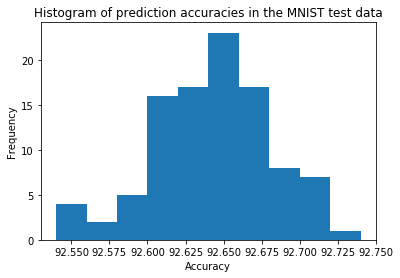

In [13]:
X_test = mnist.test.images
Y_test = np.argmax(mnist.test.labels,axis=1)

prediction_thetas = []

with tf.Session() as sess:
    for particle in theta_new:
        pack_w = np.reshape(particle[:N_FEATURES*N_CLASSES], [N_FEATURES, N_CLASSES])
        pack_b = particle[N_FEATURES*N_CLASSES:(N_FEATURES+1)*N_CLASSES]
        pack_log_lambda = particle[-1]

        prediction = sess.run(model_prediction, feed_dict= 
                              {model_x: X_test,
                               model_w: pack_w,
                               model_b: pack_b,
                               model_log_lambda: pack_log_lambda
        })
        prediction_thetas.append(prediction)

accy_test = []
for prediction_theta in prediction_thetas:
    y_trn_prd = np.argmax(prediction_theta,axis=1).astype(np.float32)
    acc = (y_trn_prd == Y_test).mean()*100
    accy_test.append(acc)

plt.hist(accy_test)
plt.title("Histogram of prediction accuracies in the MNIST test data")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")

(array([6., 1., 0., 1., 0., 0., 0., 0., 0., 2.]),
 array([-0.00049427, -0.00049396, -0.00049365, -0.00049333, -0.00049302,
        -0.0004927 , -0.00049239, -0.00049207, -0.00049176, -0.00049145,
        -0.00049113]),
 <a list of 10 Patch objects>)

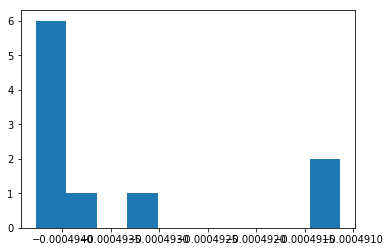

In [62]:
plt.hist(theta_new[:,0])

In [63]:
Y_pred = np.argmax(np.mean(prediction_thetas,axis=0),axis=1)
print("accuracy in predicting the test data = ", (Y_pred == Y_test).mean()*100)

('accuracy in predicting the test data = ', 91.84)


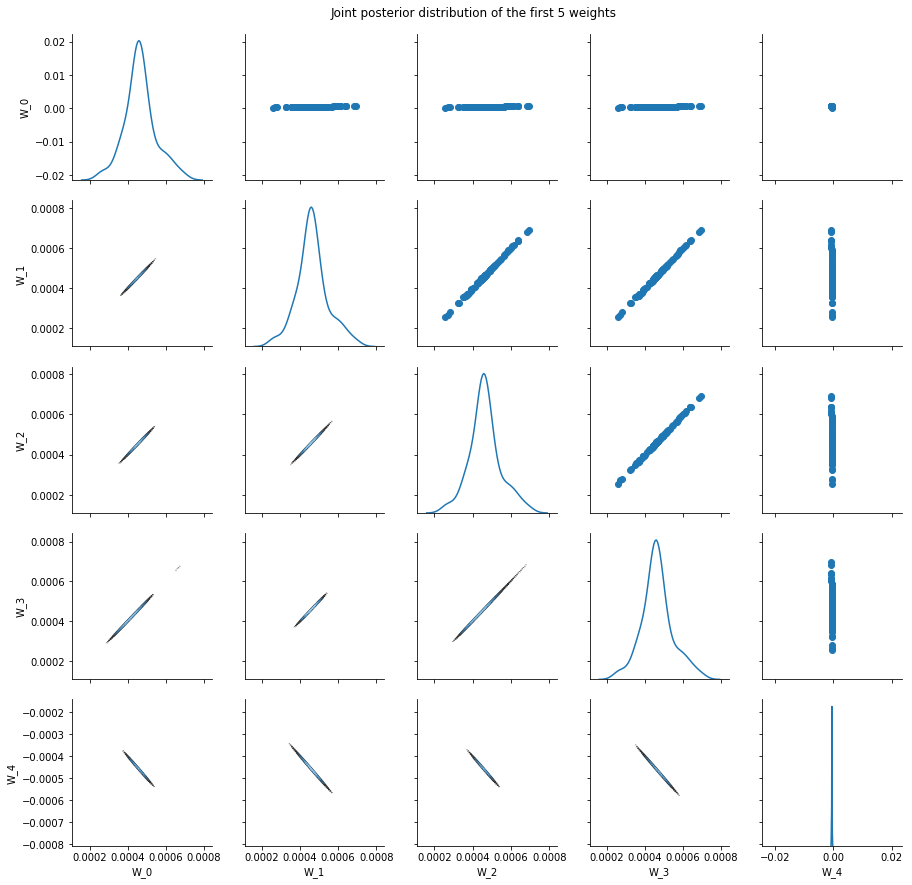

In [41]:
samples_df = pd.DataFrame(data = theta_new, index=range(M))
# Now create a small subset by taking the first 5 weights, labelled as W_0, ... , W_4.
samples_5 = pd.DataFrame(data = samples_df[list(range(5))].values,columns=["W_0", "W_1", "W_2", "W_3", "W_4"])
# We use Seaborn PairGrid to make a triale plot to show auto and cross correlations.
g = sns.PairGrid(samples_5, diag_sharey=False)
g.map_lower(sns.kdeplot, n_levels = 4,cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot,legend=False)
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Joint posterior distribution of the first 5 weights')

array([0., 0., 0., 0., 0., 1., 1., 1.])

In [26]:
m_grad_log_p

[<tf.Tensor 'model_4/gradients/AddN_4:0' shape=(784, 10) dtype=float32>,
 <tf.Tensor 'model_4/gradients/AddN_3:0' shape=(10,) dtype=float32>,
 <tf.Tensor 'model_4/gradients/model_4/Exp_grad/mul:0' shape=() dtype=float32>]

In [9]:
a = np.array([[1,2,3],[4,5,6]])

In [10]:
a

array([[1, 2, 3],
       [4, 5, 6]])

In [17]:
a[:,-1]

array([3, 6])

In [26]:
a = [[1,2],[3,4],[5,6]]

In [29]:
np.argmax(np.mean(a, axis=0),axis=0)

1